In [1]:
import os
import re
import picklea
import pandas as pd 
import numpy as np 
import scipy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise.model_selection import cross_validate
from ast import literal_eval
from surprise import Reader, Dataset, SVD

In [2]:
PATH = "../data"
print(os.listdir(PATH))

['count_matrix.npz', 'movie_scores.pkl', 'movies.pkl', 'tfidf_matrix.npz', 'tmdb_5000_movies.csv', 'movie_df.pkl', 'tmdb_5000_credits.csv']


In [3]:
credit = pd.read_csv(os.path.join(PATH, 'tmdb_5000_credits.csv'))
movie = pd.read_csv(os.path.join(PATH, 'tmdb_5000_movies.csv'))

In [4]:
credit.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [5]:
movie.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [6]:
credit.columns = ['id','tittle','cast','crew']
movie = movie.merge(credit, on='id')

In [7]:
movie.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


# **Best movies based on scores**

![](https://image.ibb.co/jYWZp9/wr.png)

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

In [8]:
C = movie['vote_average'].mean()
C

6.092171559442016

In [9]:
m = movie['vote_count'].quantile(0.9)
m

1838.4000000000015

In [10]:
q_movies = movie.copy().loc[movie['vote_count'] >= m]
q_movies.shape

(481, 23)

In [11]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']

    return (v/(v+m) * R) + (m/(m+v) * C)

In [12]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(5)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239


In [15]:
import pickle

In [17]:
with open('../data/movie_scores.pickle', 'wb') as handle:
    pickle.dump(q_movies[['id', 'title','score']], handle, protocol=pickle.HIGHEST_PROTOCOL)

# **Content based filtering**

In [18]:
movie['overview'].head(3)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
Name: overview, dtype: object

In [19]:
tfidf = TfidfVectorizer(stop_words='english')

movie['overview'] = movie['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(movie['overview'])
tfidf_matrix.shape

(4803, 20978)

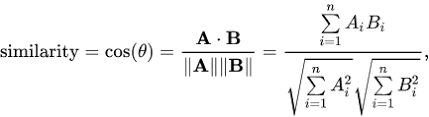

In [20]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [21]:
indices = pd.Series(movie.index, index=movie['title']).drop_duplicates()

In [22]:
scipy.sparse.save_npz('../data/tfidf_matrix.npz', tfidf_matrix)

In [23]:
with open('../data/movie_df.pickle', 'wb') as handle:
    pickle.dump(movie[["id","title"]], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    movie_similarity = [i[1] for i in sim_scores]

    return pd.DataFrame(zip(movie['title'].iloc[movie_indices], movie_similarity), columns=["title", "similarity"])

In [21]:
get_recommendations('The Godfather: Part II')

,title,similarity
0,The Godfather,0.412329
1,The Godfather: Part III,0.259649
2,An American in Hollywood,0.121267
3,A Most Violent Year,0.111731
4,Casino,0.110821


In [22]:
get_recommendations('The Lord of the Rings: The Fellowship of the Ring')

,title,similarity
0,The Hobbit: An Unexpected Journey,0.195158
1,The Hobbit: The Desolation of Smaug,0.180959
2,The Lord of the Rings: The Return of the King,0.166745
3,The Lord of the Rings: The Two Towers,0.147305
4,Underclassman,0.124586


In [23]:
get_recommendations('Pulp Fiction')

,title,similarity
0,The Sting,0.132020
1,All or Nothing,0.114761
2,Sliding Doors,0.111997
3,Locker 13,0.111056
4,The Fighter,0.101718


In [24]:
get_recommendations('The Avengers')

,title,similarity
0,Avengers: Age of Ultron,0.146374
1,Plastic,0.122791
2,Timecop,0.110385
3,This Thing of Ours,0.107529
4,Thank You for Smoking,0.106203


## add more features

In [25]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movie[feature] = movie[feature].apply(literal_eval)

In [26]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [27]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]

        if len(names) > 3:
            names = names[:3]
        return names

    return []

In [28]:
movie['director'] = movie['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movie[feature] = movie[feature].apply(get_list)

In [29]:
movie[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [30]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [31]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movie[feature] = movie[feature].apply(clean_data)

In [32]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movie['soup'] = movie.apply(create_soup, axis=1)

In [33]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie['soup'])

In [34]:
scipy.sparse.save_npz('../data/count_matrix.npz', count_matrix)

In [34]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [41]:
movie = movie.reset_index()
indices = pd.Series(movie.index, index=movie['title'])

In [37]:
get_recommendations('The Godfather: Part II', cosine_sim2)

,title,similarity
0,The Godfather: Part III,0.500000
1,The Godfather,0.421637
2,Amidst the Devil's Wings,0.365148
3,The Son of No One,0.358569
4,Apocalypse Now,0.316228


In [38]:
get_recommendations('The Lord of the Rings: The Fellowship of the Ring', cosine_sim2)

,title,similarity
0,The Hobbit: The Desolation of Smaug,0.737865
1,The Lord of the Rings: The Return of the King,0.730297
2,The Lord of the Rings: The Two Towers,0.730297
3,The Hobbit: The Battle of the Five Armies,0.700000
4,The Hobbit: An Unexpected Journey,0.700000


In [39]:
get_recommendations('Pulp Fiction', cosine_sim2)

,title,similarity
0,Kill Bill: Vol. 2,0.400000
1,S.W.A.T.,0.381385
2,The Hateful Eight,0.381385
3,A Time to Kill,0.381385
4,Lakeview Terrace,0.381385


In [40]:
get_recommendations('The Avengers', cosine_sim)

,title,similarity
0,Avengers: Age of Ultron,0.146374
1,Plastic,0.122791
2,Timecop,0.110385
3,This Thing of Ours,0.107529
4,Thank You for Smoking,0.106203


# **Collaborative Filtering**

In [2]:
reader = Reader()
movies = pd.read_csv("movielens_latest/movies.csv")
ratings = pd.read_csv("movielens_latest/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [3]:
def year_from_title(title):
    try:
        res = int(re.findall(r"\(\s*\+?(-?\d+)\s*\)", title)[0])
        return res
    except:
        return 0
    
movie_titles = movies["title"].unique()

movies["year"] = movies["title"].apply(year_from_title)
movies = movies[movies["year"] > 1995]

In [4]:
movies.head()

,movieId,title,genres,year
60,61,Eye for an Eye (1996),Drama|Thriller,1996
62,63,Don't Be a Menace to South Central While Drink...,Comedy|Crime,1996
63,64,Two if by Sea (1996),Comedy|Romance,1996
64,65,Bio-Dome (1996),Comedy,1996
65,66,Lawnmower Man 2: Beyond Cyberspace (1996),Action|Sci-Fi|Thriller,1996


In [5]:
movies = movies.loc[:,["movieId","title"]]
ratings = ratings.loc[:,["userId","movieId","rating"]]

data = pd.merge(movies,ratings)

In [6]:
most_rated_movies = data["title"].value_counts()[:1000].keys()
data_subset = data[data['title'].isin(most_rated_movies)]

In [7]:
ratings = data_subset[['userId', 'movieId', 'rating']]

In [8]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [10]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=2)

{'test_rmse': array([0.8418665 , 0.84120905]),
 'test_mae': array([0.63328812, 0.63259917]),
 'fit_time': (278.0720565319061, 294.41121006011963),
 'test_time': (64.97606134414673, 61.09527516365051)}

In [11]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [101]:
def get_recommendations(data, user_id, num=11):
    movie_titles = data["movieId"].unique()

    rating_predictions = [(movie_id, svd.predict(user_id, int(movie_id))) for movie_id in movie_titles]
    rating_predictions = sorted(rating_predictions, key=lambda x: x[1].est, reverse=True)
    rating_predictions = rating_predictions[1:num]
    movie_indices = [i[0] for i in rating_predictions]
    movie_rating = [i[1].est for i in rating_predictions]
    
    return pd.DataFrame(zip(data[data['movieId'].isin(movie_indices)]["title"], movie_rating), columns=["title", "rating"])

In [102]:
get_recommendations(movies, 3)

[    61     63     64 ... 193880 193882 193886]


,title,rating
0,When We Were Kings (1996),4.472399
1,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.466018
2,Catch Me If You Can (2002),4.444884
3,"Lives of Others, The (Das leben der Anderen) (...",4.427043
4,"Prestige, The (2006)",4.415165
5,Inception (2010),4.406862
6,Harry Potter and the Deathly Hallows: Part 1 (...,4.387350
7,Harry Potter and the Deathly Hallows: Part 2 (...,4.385442
8,Intouchables (2011),4.367697
9,The Imitation Game (2014),4.366951


In [97]:
svd.predict(4, 66)

Prediction(uid=4, iid=66, r_ui=None, est=3.7224268615951472, details={'was_impossible': False})